In [ ]:
Lectures 6: Stratigraphic sequences

In [30]:
nb_list = !jupyter notebook list
server = [l for l in nb_list if 'eos423' in l][0].split(' :: ')[0]
prefix = server.split('?')[0]
token = server.split('?')[1]
notebook = 'Lecture06_StratigraphicSequences.ipynb'
url = prefix+'notebooks/'+notebook+'?'+token
!decktape -s '1920x1080' rise $url pdf_slides/Lecture06_StratigraphicSequences.pdf

Loading page http://localhost:8888/notebooks/Lectures07-9_StratigraphicSequences.ipynb?token=5937d7ea442aade7dc27bf992142d25f4863f0a71809c743 ...
actions jupyter-notebook:find-and-replace does not exist, still binding it in case it will be defined later...
load_extensions {
  '0': 'nbextensions_configurator/config_menu/main',
  '1': 'contrib_nbextensions_help_item/main',
  '2': 'rise/main',
  '3': 'jupyter-js-widgets/extension',
  '4': 'jupyter-black-master/jupyter-black',
  '5': 'toc2/main',
  '6': 'hide_code/hide_code',
  '7': 'hide_input/main',
  '8': 'codefolding/main',
  '9': 'splitcell/splitcell'
}
Loaded moment locale en-gb
Failed to load resource: the server responded with a status of 404 (Not Found)
HTML Sanitizer div.style changed {
  change: 'changed',
  tagName: 'div',
  attribName: 'style',
  oldValue: 'display:flex;height:60vh',
  newValue: 'display: flex ; height: 60vh'
}
HTML Sanitizer div.style changed {
  change: 'changed',
  tagName: 'div',
  attribName: 'style',
  o

In [1]:
from scipy.linalg import solve_banded
from scipy.interpolate import interp1d
import numpy as np
from tqdm.notebook import tqdm
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import clear_output
import seaborn as sns
import matplotlib.cm as cm
import time


%matplotlib inline

class Diffuse1D:
    def __init__(self, length, spacing, tstep, left, right, K, var_K):
        self.x = np.arange(0, length, spacing)
        self.u = (
            left - self.x * (left - right) / length
        )  # sets initial to steady state solution
        
        self.u = (
            left - self.x * (left - right) / length
        )  # sets initial to steady state solution
        #         self.u = np.zeros(self.x.shape)+right
        N = self.x.size
        self.var_K = var_K
        self.tstep = tstep
        self.spacing = spacing
        self.K = K
        k_arr = K * np.ones((N))  # m^2/yr
        self.r = k_arr * (self.tstep / (2 * spacing ** 2))  ##Fourier number
        self.time = 0
        self.base_level_fun = interp1d([0, 1], [0, 0], bounds_error=False, fill_value=0)
        self.base_level = self.base_level_fun(self.time)
        self.sed_Q = 10 / spacing  # not sure if spacing is correct here
        self.subsidence_r = 0.025 * 1e-3 * 1e1  # not in use yet
        self.left = left
        self.right = right
        self.rml=np.zeros(k_arr.size)
        k_bounds = np.array([k_arr[0],*k_arr,k_arr[-1]]).ravel()
        
        for i in range(self.rml.size):
            self.rml[i]=k_bounds[i+1]-k_bounds[i-1]
            
        kappa = self.tstep*(self.rml)/(8*self.spacing)


        # initialize matrices A, B and b array
        self.A = np.zeros((N, N))
        self.B = np.zeros((N, N))
        self.b = np.zeros((N))
        self.Ab = np.zeros((3, N))
        
        np.fill_diagonal(self.B, 1 - 2 * self.r)
        np.fill_diagonal(self.B[1:], kappa[1:]+self.r[1:])
        np.fill_diagonal(self.B[:, 1:], self.r[:-1]-kappa[:-1])

        self.Ab[0, 1:] = -kappa[1:] - self.r[1:]
        self.Ab[1, :] = 1 + 2 * self.r
        self.Ab[2, :-1] = kappa[:-1] - self.r[:-1]
        
#         np.fill_diagonal(self.B, 1 - 2 * self.r)
#         np.fill_diagonal(self.B[1:], self.r[1:])
#         np.fill_diagonal(self.B[:, 1:], self.r[:-1])
#         self.Ab[0, 1:] = -1 * self.r[:-1]
#         self.Ab[1, :] = 1 + 2 * self.r
#         self.Ab[2, :-1] = -1 * self.r[1:]
        
        
        # define matrices A, B and b array  ##THIS STEP IS SLOW -- but only called once
        # see method update_K() for fast version
        for i in range(N):
            if i == 0:  # first
                self.b[i] = left  # boundary condition at i=1
            elif i == N - 1:  # last
                self.b[i] =  right  # boundary condition at i=N

        #von nuemann bottom
#         self.A[-1,-1] = 1+self.r[-1]
#         self.B[-1,-1] = 1-self.r[-1]
#         self.b[-1]=0
        
        self.Q = np.zeros((N))
        self.bb = self.B.dot(self.u) + 2 * self.r*self.b + self.tstep*self.Q

        self.update_coastline()

    def set_baselevel(self, time, rsl):
        # can pass a set of paired time/rsl and model will interpolate for each dt
        self.base_level_fun = interp1d(time, rsl)

    def run_step(self):
        if self.var_K:
            self.update_K()  # can disable if K is not changing with each t_step (ie as a function of elevation)
        self.Q *= 0  # clearing any old sed flux terms
        self.base_level = self.base_level_fun(self.time)  # update base level
        self.update_coastline()  # select coastline point for sed flux
        self.Q[self.coastline] += self.sed_Q  # add sediment to the coastline
#         self.b[-1]=self.u[-1]
#         self.b[0]=self.u[0]
        self.bb = self.B.dot(self.u) + 2 * self.r*self.b + self.tstep*self.Q  # quick matrix addition
        self.u = solve_banded(
            (1, 1), self.Ab, self.bb
        )  # this step solves the Crank-Nicholson matrix for next timestep
        self.time += self.tstep  # increment timestep

    def set_left(self, left):
        # function to change boundary condition
        self.b[0] = left

    def set_u(self, u):
        self.u = u

    def set_right(self, right):
        # function to change boundary condition
        self.b[-1] = right

    def update_coastline(self):
        # finds the first grid point below base level starting on the left hand side
        try:
            self.coastline = np.where(self.u < (self.base_level))[0][0]
        except:
            self.coastline = 0

    def update_K(self):
        # updates K if you need it to change with each timestep
        # the tridiagonal matrix forms below dont need to be inverted, so this is
        # a much faster form of setting up the Crank-Nicolson solution
        k_arr = self.K * np.ones((self.x.size))
        k_arr[: self.coastline] = 1e-2
        swb = np.where(self.u < (self.base_level - 25))[0][0] #lower K below SWB?
        k_arr[swb:] = 1e-2
        self.r = k_arr * (self.tstep / (2 * self.spacing ** 2))  ##Fourier number
        k_bounds = np.array([k_arr[0],*k_arr,k_arr[-1]]).ravel()

        self.rml=k_bounds[2:]-k_bounds[:-2]
            
        kappa = self.tstep*(self.rml)/(8*self.spacing)
        
        np.fill_diagonal(self.B, 1 - 2 * self.r)
        np.fill_diagonal(self.B[1:], kappa[1:]+self.r[1:])
        np.fill_diagonal(self.B[:, 1:], self.r[:-1]-kappa[:-1])

        self.Ab[0, 1:] = -kappa[:-1] - self.r[:-1]
        self.Ab[1, :] = 1 + 2 * self.r
        self.Ab[2, :-1] = kappa[1:] - self.r[1:]
        
        #should the R_i match??  go back a few steps and check the full form
        
        #von nuemann bottom
#         self.Ab[1, -1] = 1+self.r[-1]
#         self.B[-1,-1] = 1-self.r[-1]
#         self.b[-1]=0
#         self.b[0] = self.left
#         self.b[-1] = self.right

def animate_beds(beds,otime,rsl, color=True, aspect=10, ymin=-55, ymax=10):
    N = int(len(beds) / 2) + 1
    cs_reg = sns.color_palette("viridis", n_colors=np.sum(np.gradient(rsl) <= 0))
    cs_trans = sns.color_palette("Greys", n_colors=np.sum(np.gradient(rsl) > 0))
    rsl_down = np.gradient(rsl) <= 0
    if color==False:
        cs_reg = sns.color_palette("Greys", n_colors=100*np.sum(np.gradient(rsl) <= 0))
        cs_trans = sns.color_palette("Greys", n_colors=100*np.sum(np.gradient(rsl) > 0))

    sns.set_palette("tab20", n_colors=40)
    
    minima = min(np.gradient(rsl))
    maxima = max(np.gradient(rsl))
    max_max = max([minima,maxima])

    norm = matplotlib.colors.Normalize(vmin=-1*max_max, vmax=max_max, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.seismic)
    
    norm = matplotlib.colors.Normalize(vmin=1e10, vmax=1e11, clip=False)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Greys)

    # for k in range(len(beds)):
    #         beds[k]-=otime[k]*model.subsidence_r

    beds = np.array(beds)
    for i, bed in enumerate(beds):

        beds_eroded = []

        for k, layer in enumerate(beds[:i]):
            future_min = np.min(beds[k : i + 1], axis=0)
            beds_eroded.append(future_min)
        #         beds_eroded.append(layer)

        beds_eroded.append(beds[i])
        beds_eroded = np.array(beds_eroded)

        fig = plt.figure(figsize=(18, 12))
        clear_output(wait=True)
        c = [0, 0]
        z = N + 1
        last_layer = beds_eroded[0]
        for layer, down in zip(beds_eroded[: i + 1], np.gradient(rsl)):
            if down:
                plt.fill_between(
                    np.arange(layer.size),
                    last_layer,
                    layer,
                    facecolor=mapper.to_rgba(down),
                    lw=0.5,
                    edgecolor=(0, 0, 0),
                )
                c[0] += 1
            else:
                plt.fill_between(
                    np.arange(layer.size),
                    last_layer,
                    layer,
                    facecolor=cs_trans[c[1]],
                    lw=0.1,
                    edgecolor=(0, 0, 0),
                )
                c[1] += 1
            z -= 1
            last_layer = np.copy(layer)

        plt.plot(bed, color="r", zorder=N * 2 + 1)
        plt.plot([0, 1000], [rsl[i], rsl[i]], "--", color="k")

        plt.gca().set_xlim([0, layer.size])
        plt.gca().set_ylim([ymin, ymax])
        plt.gca().set_aspect(aspect)
        #     plt.gca().set_title('Regression (color) and Transgression (greyscale)\n with Constant Sed Flux (vertical exaggeration: 100)')
        plt.gca().set_title("time=" + str(np.round(otime[i], 2)) + " years")
        plt.gca().set_ylabel("height (m)")
        plt.gca().set_xlabel("distance (10^1 meters)")
        plt.show()
        time.sleep(0.01)
        
def plot_beds(beds,otime,rsl, color=True, aspect=10, ymin=-55):
    N = int(len(beds) / 2) + 1
    cs_reg = sns.color_palette("viridis", n_colors=np.sum(np.gradient(rsl) <= 0))
    cs_trans = sns.color_palette("Greys", n_colors=np.sum(np.gradient(rsl) > 0))
    rsl_down = np.gradient(rsl) <= 0
    if color==False:
        cs_reg = sns.color_palette("Greys", n_colors=100*np.sum(np.gradient(rsl) <= 0))
        cs_trans = sns.color_palette("Greys", n_colors=100*np.sum(np.gradient(rsl) > 0))

    sns.set_palette("tab20", n_colors=40)
    
    minima = min(np.gradient(rsl))
    maxima = max(np.gradient(rsl))
    max_max = max([minima,maxima])

    norm = matplotlib.colors.Normalize(vmin=-1*max_max, vmax=max_max, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.seismic)
    
    if color==False:
        norm = matplotlib.colors.Normalize(vmin=0, vmax=1e10, clip=False)
        mapper = cm.ScalarMappable(norm=norm, cmap=cm.Greys)

    # for k in range(len(beds)):
    #         beds[k]-=otime[k]*model.subsidence_r

    beds = np.array(beds)


    beds_eroded = []

    for k, layer in enumerate(beds):
        future_min = np.min(beds[k :], axis=0)
        beds_eroded.append(future_min)
    #         beds_eroded.append(layer)

    beds_eroded.append(beds[-1])
    beds_eroded = np.array(beds_eroded)

    fig = plt.figure(figsize=(18, 12))
    clear_output(wait=True)
    c = [0, 0]
    z = N + 1
    last_layer = beds_eroded[0]
    for layer, down in zip(beds_eroded, np.gradient(rsl)):
        if down:
            for depth in [0,10]:
                plt.fill_between(
                    np.arange(layer.size),
                    last_layer,
                    layer,
                    facecolor=mapper.to_rgba(down),
                    lw=0.5,
                    edgecolor=(0, 0, 0),
                )
            c[0] += 1
        else:
            plt.fill_between(
                np.arange(layer.size),
                last_layer,
                layer,
                facecolor=cs_trans[c[1]],
                lw=0.1,
                edgecolor=(0, 0, 0),
            )
            c[1] += 1
        z -= 1
        last_layer = np.copy(layer)

    plt.plot(beds[-1], color="r", zorder=N * 2 + 1)
#     plt.plot([0, 1000], [rsl[-1], rsl[i]], "--", color="k")

    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([ymin, 0])
    plt.gca().set_aspect(aspect)
    #     plt.gca().set_title('Regression (color) and Transgression (greyscale)\n with Constant Sed Flux (vertical exaggeration: 100)')
    plt.gca().set_title("time=" + str(np.round(otime[-1], 2)) + " years")
    plt.gca().set_ylabel("height (m)")
    plt.gca().set_xlabel("distance (10^1 meters)")
    return plt.gca()

In [2]:
def plt_strat():
    beds_eroded = []
    for i,layer in enumerate(beds):
        future_min = np.min(beds[i:],axis=0)
        beds_eroded.append(future_min)

    N=int(len(beds_eroded)/2)+1
    cs_reg=sns.color_palette('viridis',n_colors=np.sum(np.gradient(rsl)<=0))
    cs_trans=sns.color_palette('Greys',n_colors=np.sum(np.gradient(rsl)>0))
    rsl_down=np.gradient(rsl)<=0

    minima = min(np.gradient(rsl))
    maxima = max(np.gradient(rsl))
    max_max = max([minima,maxima])

    norm = matplotlib.colors.Normalize(vmin=-1*max_max, vmax=max_max, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdBu)

    sns.set_palette('tab20',n_colors=40)
    fig=plt.figure(figsize=(8,12))
    for k in range(1,10):
        plt.subplot(1,9,k)
        c=[0,0]
        z=N+1
        last_layer=beds_eroded[0]
        for layer,down in zip(beds_eroded,np.gradient(rsl)):
            if True:
                plt.fill_between(np.arange(layer.size),last_layer,layer,facecolor=mapper.to_rgba(down),lw=0,edgecolor=(0,0,0))
        #         plt.plot(layer,c=cs_reg[c[0]],zorder=z)
                c[0]+=1
            else:
                plt.fill_between(np.arange(layer.size),last_layer,layer,facecolor=cs_trans[c[1]],lw=0,edgecolor=(0,0,0))
                c[1]+=1
            z-=1
            last_layer=np.copy(layer)
        plt.gca().set_xlim([k*100/2,k*100/2+0.01])
        plt.gca().set_ylim([-100,10])
        plt.gca().set_aspect(.001)
        plt.gca().set_title(str(k/2)+' km',fontsize=12)
        plt.gca().set_xticks([])
        if k==1:
            plt.gca().set_ylabel('height (m)')
        else:
            plt.gca().set_yticks([])
    return fig

In [3]:
sns.set_palette('viridis',n_colors=11)

In [4]:
dt = .01
total_time = 2000
base_level_rise=5

model = Diffuse1D(length=10000, spacing=10, tstep=dt, left=10, right=-200, K=1e2, var_K=False)
xt = np.linspace(0, 10000, 10000)

model.set_baselevel(xt, -10 * np.sin(xt * 3e-2) + base_level_rise / (total_time) * xt - 25)

beds = []
otime = []
rsl = []
# plt.plot(model.u)

beds.append(model.u)
otime.append(model.time)
rsl.append(model.base_level)


pbar = tqdm(range(int(total_time / dt)+1))
for k in pbar:
    model.run_step()
    #     model.set_left(model.base_level+10)
    if k % 2000 == 0:
        pbar.set_description("Processing year %s" % np.round(model.time, 1))
        beds.append(model.u)
        otime.append(model.time)
        rsl.append(model.base_level)

<center><div style="background: url(images/stratigraphy.png) 50% 75% no-repeat;
  width: 75vw;
  height: 30vh; background-size: 100%;">
</div></center>

# Lectures 6-7: Stratigraphic Sequences

<div style='font-size:25px'>  
   
1. Hands on with our transport model
    1. Constant Subsidence and Constant Sediment Flux
        1. Shut off sediment source
    1. Variable Sea Level and Constant Sediment Flux    
1. Stratigraphic Sections: blind men and the elephant
    1. Context


</div>

<div style='font-size:25px'> <i>We acknowledge and respect the lək̓ʷəŋən peoples on whose traditional territory the university stands and the Songhees, Esquimalt and W̱SÁNE&#262; peoples whose historical relationships with the land continue to this day.</i></div>

# A more powerful diffusion model
We now have a fairly powerful 1-D diffusive transport model and will begin exploring the stratigraphic **architecture** of a basin is a function of:
1. transport
2. sediment supply
3. accommodation space

<span style='color:DodgerBlue'>**Why are we interested in understanding these processes?**</span>

Sedimentary basins are the records of past environments -- so if we want to reconstruct the past we need to understand how these sequences record time and how to correlate from section to section.

# Constant Sediment Flux

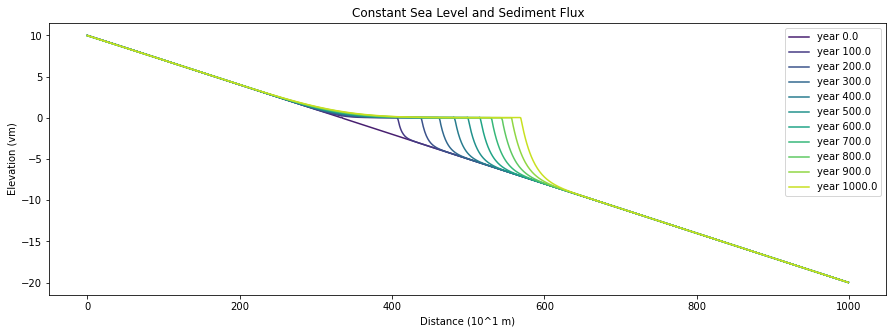

In [5]:
fig=plt.figure(figsize=(15,5))
dt = .1
total_time = 1000
base_level_rise=0
sns.set_palette('viridis',n_colors=11)
model = Diffuse1D(length=10000, spacing=10, tstep=dt, left=10, right=-20, K=2e2, var_K=False)
xt = np.linspace(0, total_time, 1000)
model.set_baselevel(xt, base_level_rise/total_time*xt)
beds = []
otime = []
rsl = []
beds.append(model.u)
otime.append(model.time)
rsl.append(model.base_level)
for k in range(int(total_time / dt)):
    model.run_step()
    #     model.set_left(model.base_level+10)
    if k % 10 == 0:
        pbar.set_description("Processing year %s" % np.round(model.time, 1).astype(int))
        beds.append(model.u)
        otime.append(model.time)
        rsl.append(model.base_level)
    if k % 1000 == 0:
        plt.plot(model.u,label="year %s" % np.round(model.time, 0))              
plt.plot(model.u,label="year %s" % np.round(model.time, 0))
plt.gca().set_xlabel('Distance (10^1 m)')
plt.gca().set_ylabel('Elevation (vm)')
plt.gca().set_title('Constant Sea Level and Sediment Flux')
_=plt.legend(loc='best')

# Constant Sediment Flux

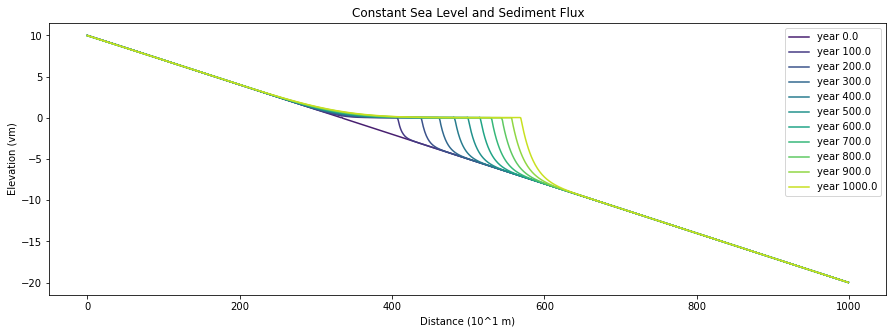

In [6]:
fig

<span style='color:DodgerBlue'>**Is there any erosion?**</span>

<span style='color:DodgerBlue'>**What happens if we shut off sedimentation rate after some amount of time? What happens to the coastline?**</span>

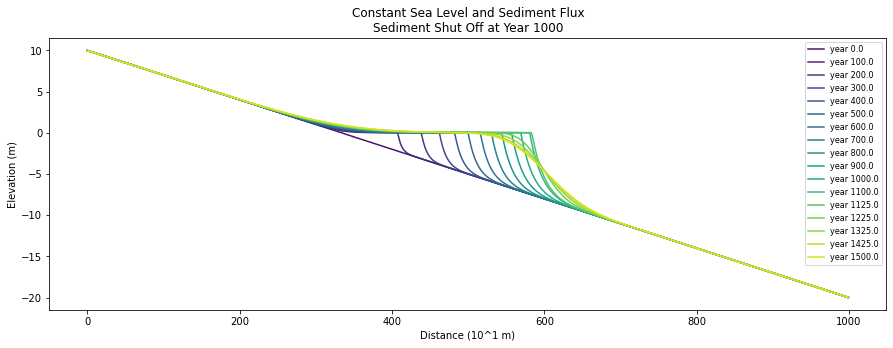

In [7]:
fig=plt.figure(figsize=(15,5))
dt = .1
total_time = 1500
base_level_rise=0

model = Diffuse1D(length=10000, spacing=10, tstep=dt, left=10, right=-20, K=2e2, var_K=False)
xt = np.linspace(0, total_time, 1000)
model.set_baselevel(xt, base_level_rise/total_time*xt)

beds = []
otime = []
rsl = []

beds.append(model.u)
otime.append(model.time)
rsl.append(model.base_level)
sns.set_palette('viridis',n_colors=int(total_time / dt / 1000)+2)

for k in range(int(.75*total_time / dt)):
    model.run_step()
    #     model.set_left(model.base_level+10)
    if k % 10 == 0:
        pbar.set_description("Processing year %s" % np.round(model.time, 1).astype(int))
        beds.append(model.u)
        otime.append(model.time)
        rsl.append(model.base_level)
    if k % 1000 == 0:
        plt.plot(model.u,label="year %s" % np.round(model.time, 0))


model.sed_Q=0
for k in range(int(.25*total_time / dt)):
    model.run_step()
    #     model.set_left(model.base_level+10)
    if k % 10 == 0:
        pbar.set_description("Processing year %s" % np.round(model.time, 1).astype(int))
        beds.append(model.u)
        otime.append(model.time)
        rsl.append(model.base_level)
    if k % 1000 == 0:
        plt.plot(model.u,label="year %s" % np.round(model.time, 0))
               
plt.plot(model.u,label="year %s" % np.round(model.time, 0))
plt.gca().set_xlabel('Distance (10^1 m)')
plt.gca().set_ylabel('Elevation (m)')
plt.gca().set_title('Constant Sea Level and Sediment Flux\nSediment Shut Off at Year 1000')
_=plt.legend(loc='best',fontsize=8)

<span style='color:DodgerBlue'>**What happens if we shut off sedimentation rate after some amount of time? What happens to the coastline?**</span>

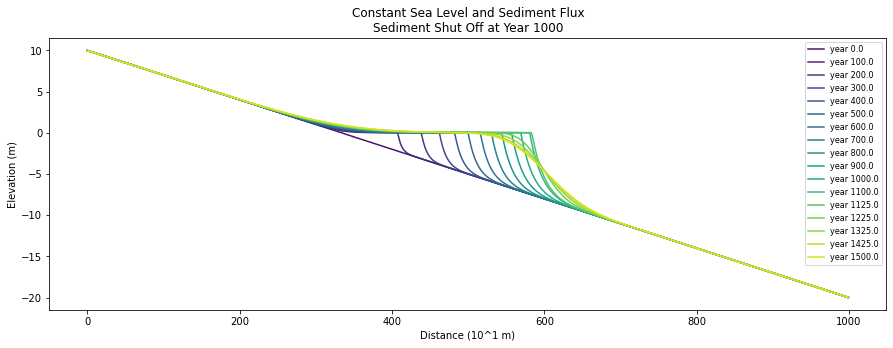

In [8]:
fig

<span style='color:DodgerBlue'>**What happens if the sediment flux returns?**</span>

# Example 1: Constant Sea Level Change and Constant Sediment Flux
Now it is your turn to play with your model. Initialize your model with same boundary conditions from assignment 2 (set initial topography to the steady state solution -- a line).

```python
#fix right and left boundaries
left_boundary = 10
right_boundary = -20
#set diffusivity
K = 2e2
#sediment flux at coastline
sed_Q = 10 #m^2/yr
```

You will run your model for 1000 years. In one simulation, bring sea level up **5 meters** over the 1000 years (linearly). In a second simulation, drop sea level by **5 meters** over the 1000 years. Answer the following questions for each simulation (it can help to plot the topography every 100 years or so). 


<span style='color:DodgerBlue;'>  
    
1. **What does the coastline do?**
1. **Where is erosion occurring?**
    
</span>

In [6]:
number_of_loops = 100
topography = -30/1000*np.linspace(0,1000,1000)+10
sea_level = np.linspace(0,1000,number_of_loops)*(5/1000)
sl = 0
for i in range(number_of_loops):
    sl_at_this_timestep = sea_level[i]  
#     print(sl_at_this_timestep)
    for k in range(len(topography)):
        if topography[k]<sl_at_this_timestep:
            coastline = k
#             print(k)
            break
    
#     ## np.where
#     np.where(topography<=sl_at_this_timestep)[0][0]
    
#     np.argmin(np.abs(topography-sl_at_this_timestep))

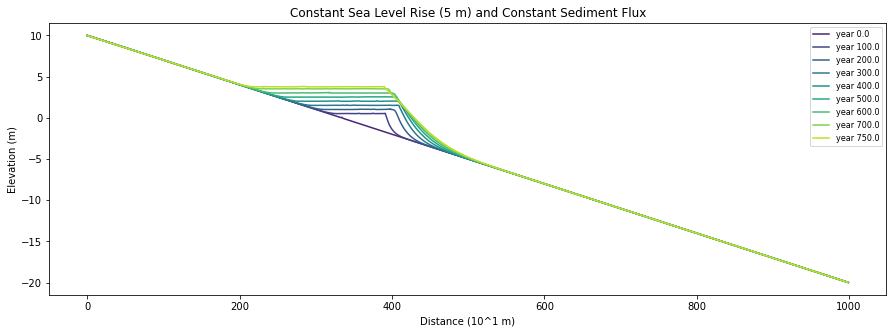

In [11]:
fig=plt.figure(figsize=(15,5))
dt = .1
total_time = 1000
base_level_rise=5

model = Diffuse1D(length=10000, spacing=10, tstep=dt, left=10, right=-20, K=2e2, var_K=False)
xt = np.linspace(0, total_time, 1000)
model.set_baselevel(xt, base_level_rise/total_time*xt)

beds = []
otime = []
rsl = []

beds.append(model.u)
otime.append(model.time)
rsl.append(model.base_level)

sns.set_palette('viridis',n_colors=int((.75*total_time / dt)/1000) + 2)

for k in range(int(.75*total_time / dt)):
    model.run_step()
    #     model.set_left(model.base_level+10)
    if k % 10 == 0:
        pbar.set_description("Processing year %s" % np.round(model.time, 1).astype(int))
        beds.append(model.u)
        otime.append(model.time)
        rsl.append(model.base_level)
    if k % 1000 == 0:
        plt.plot(model.u,label="year %s" % np.round(model.time, 0))
               
plt.plot(model.u,label="year %s" % np.round(model.time, 0))
plt.gca().set_xlabel('Distance (10^1 m)')
plt.gca().set_ylabel('Elevation (m)')
plt.gca().set_title('Constant Sea Level Rise (5 m) and Constant Sediment Flux')
_=plt.legend(loc='best',fontsize=8)

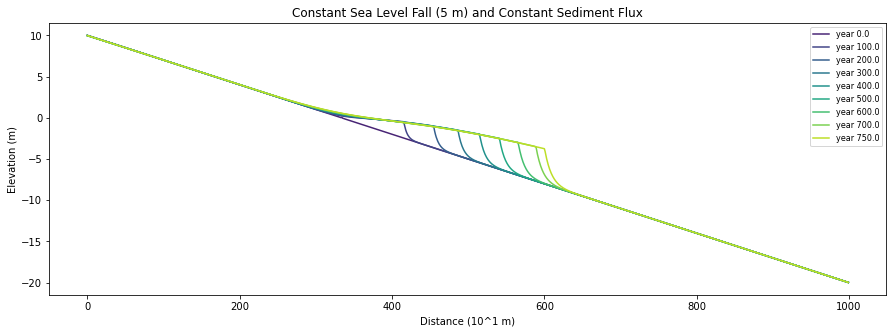

In [12]:
fig=plt.figure(figsize=(15,5))
dt = .1
total_time = 1000
base_level_rise=-5

model = Diffuse1D(length=10000, spacing=10, tstep=dt, left=10, right=-20, K=2e2, var_K=False)
xt = np.linspace(0, total_time, 1000)
model.set_baselevel(xt, base_level_rise/total_time*xt)

beds = []
otime = []
rsl = []

beds.append(model.u)
otime.append(model.time)
rsl.append(model.base_level)

sns.set_palette('viridis',n_colors=int((.75*total_time / dt)/1000) + 2)

for k in range(int(.75*total_time / dt)):
    model.run_step()
    #     model.set_left(model.base_level+10)
    if k % 10 == 0:
        pbar.set_description("Processing year %s" % np.round(model.time, 1).astype(int))
        beds.append(model.u)
        otime.append(model.time)
        rsl.append(model.base_level)
    if k % 1000 == 0:
        plt.plot(model.u,label="year %s" % np.round(model.time, 0))
               
plt.plot(model.u,label="year %s" % np.round(model.time, 0))
plt.gca().set_xlabel('Distance (10^1 m)')
plt.gca().set_ylabel('Elevation (m)')
plt.gca().set_title('Constant Sea Level Fall (5 m) and Constant Sediment Flux')
_=plt.legend(loc='best',fontsize=8)

# Example 2: Sea Level Change and Constant Sed Flux
Now let's combine the past last two simulations. First drop sea level by 5 meters over 1000 years (**regression**), then bring sea level back up 5 meters over 1000 years (**transgression**). Answer the following questions:

<span style='color:DodgerBlue;'>  
    
1. **What does the coastline do? Specifically when does it change direction?**
1. **When and where is erosion occurring?**
1. **Describe the contact between year 1200 deposits and year 800 deposits**
    1. What is the coastline doing at this time?
1. **Describe the contact between year 1900 deposits and year 100 deposits**
    1. What is the coastline doing at this time?
</span>

The geometry of steeper-dipping beds that terminate against beds with shallower dip is called **downlap** *(Coastline is generally regressing, or prograding)*. The geometry shallowly dipping strata terminating against more steeply dipping strata is called **onlap** *(Coastline is generally transgressing)*.

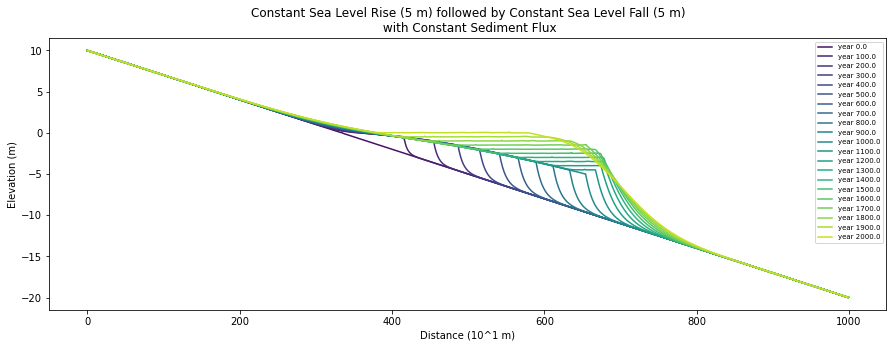

In [14]:
sns.set_palette('viridis',n_colors=21)
fig=plt.figure(figsize=(15,5))
dt = .1
total_time = 2000
base_level_rise=5

model = Diffuse1D(length=10000, spacing=10, tstep=dt, left=10, right=-20, K=2e2, var_K=False)
xt = np.linspace(0, total_time, 1000)
RSL = np.zeros(xt.size)
RSL[:500]= -1*base_level_rise/(total_time/2)*xt[:500]
RSL[500:] =  base_level_rise/(total_time/2)*xt[500:]-2*base_level_rise
model.set_baselevel(xt, RSL)
beds = []
otime = []
rsl = []
beds.append(model.u)
otime.append(model.time)
rsl.append(model.base_level)
sns.set_palette('viridis',n_colors=int((total_time / dt)/1000) + 2)
for k in range(int(total_time / dt)):
    model.run_step()
    #     model.set_left(model.base_level+10)
    if k % 10 == 0:
        pbar.set_description("Processing year %s" % np.round(model.time, 1).astype(int))
        beds.append(model.u)
        otime.append(model.time)
        rsl.append(model.base_level)
    if k % 1000 == 0:
        plt.plot(model.u,label="year %s" % np.round(model.time, 0))         
plt.plot(model.u,label="year %s" % np.round(model.time, 0))
plt.gca().set_xlabel('Distance (10^1 m)')
plt.gca().set_ylabel('Elevation (m)')
plt.gca().set_title('Constant Sea Level Rise (5 m) followed by Constant Sea Level Fall (5 m)\n with Constant Sediment Flux')
_=plt.legend(loc='best',fontsize=7)

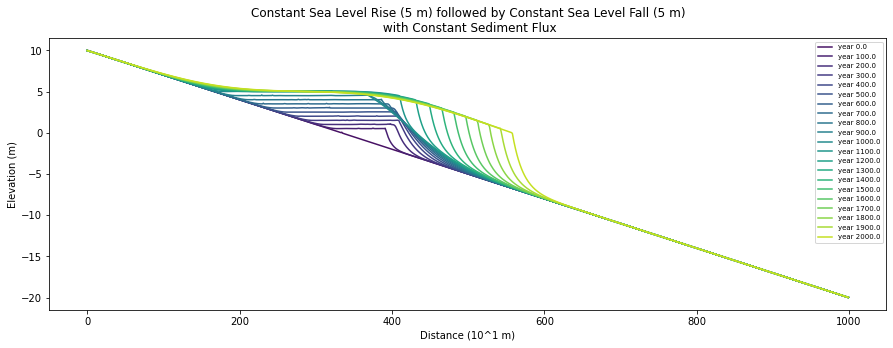

In [15]:
sns.set_palette('viridis',n_colors=21)
fig=plt.figure(figsize=(15,5))
dt = .1
total_time = 2000
base_level_rise=-5
model = Diffuse1D(length=10000, spacing=10, tstep=dt, left=10, right=-20, K=2e2, var_K=False)
xt = np.linspace(0, total_time, 1000)
RSL = np.zeros(xt.size)
RSL[:500]= -1*base_level_rise/(total_time/2)*xt[:500]
RSL[500:] =  base_level_rise/(total_time/2)*xt[500:]-2*base_level_rise
model.set_baselevel(xt, RSL)
beds = []
otime = []
rsl = []
beds.append(model.u)
otime.append(model.time)
rsl.append(model.base_level)
sns.set_palette('viridis',n_colors=int((total_time / dt)/1000) + 2)
for k in range(int(total_time / dt)):
    model.run_step()
    #     model.set_left(model.base_level+10)
    if k % 10 == 0:
        pbar.set_description("Processing year %s" % np.round(model.time, 1).astype(int))
        beds.append(model.u)
        otime.append(model.time)
        rsl.append(model.base_level)
    if k % 1000 == 0:
        plt.plot(model.u,label="year %s" % np.round(model.time, 0))             
plt.plot(model.u,label="year %s" % np.round(model.time, 0))
plt.gca().set_xlabel('Distance (10^1 m)')
plt.gca().set_ylabel('Elevation (m)')
plt.gca().set_title('Constant Sea Level Rise (5 m) followed by Constant Sea Level Fall (5 m)\n with Constant Sediment Flux')
_=plt.legend(loc='best',fontsize=7)

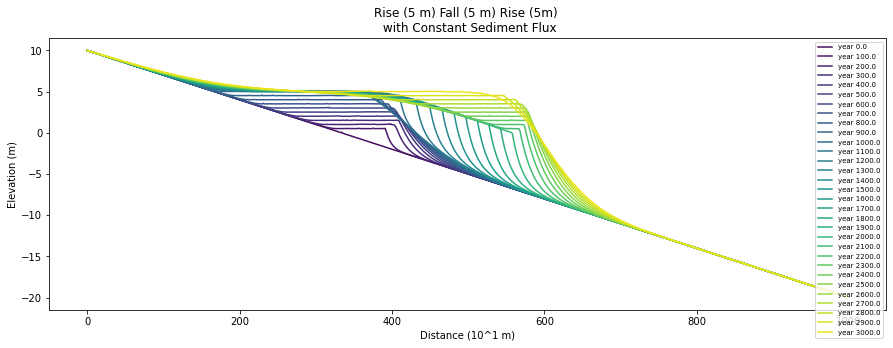

In [16]:
sns.set_palette('viridis',n_colors=31)
fig=plt.figure(figsize=(15,5))
dt = .1
total_time = 3000
base_level_rise=-5
model = Diffuse1D(length=10000, spacing=10, tstep=dt, left=10, right=-20, K=2e2, var_K=False)
xt = np.linspace(0, total_time, 1500)
RSL = np.zeros(xt.size)
RSL[:500]= -1*base_level_rise/(total_time/3)*xt[:500]
RSL[500:1000] =  1*base_level_rise/(total_time/3)*xt[:500]+5
RSL[1000:] =  -1*base_level_rise/(total_time/3)*xt[:500]
model.set_baselevel(xt, RSL)
beds = []
otime = []
rsl = []
beds.append(model.u)
otime.append(model.time)
rsl.append(model.base_level)
for k in range(int(total_time / dt)):
    model.run_step()
    #     model.set_left(model.base_level+10)
    if k % 10 == 0:
        pbar.set_description("Processing year %s" % np.round(model.time, 1).astype(int))
        beds.append(model.u)
        otime.append(model.time)
        rsl.append(model.base_level)
    if k % 1000 == 0:
        plt.plot(model.u,label="year %s" % np.round(model.time, 0))          
plt.plot(model.u,label="year %s" % np.round(model.time, 0))
plt.gca().set_xlabel('Distance (10^1 m)')
plt.gca().set_ylabel('Elevation (m)')
plt.gca().set_title('Rise (5 m) Fall (5 m) Rise (5m) \n with Constant Sediment Flux')
_=plt.legend(loc='best',fontsize=7)

(200.0, 800.0)

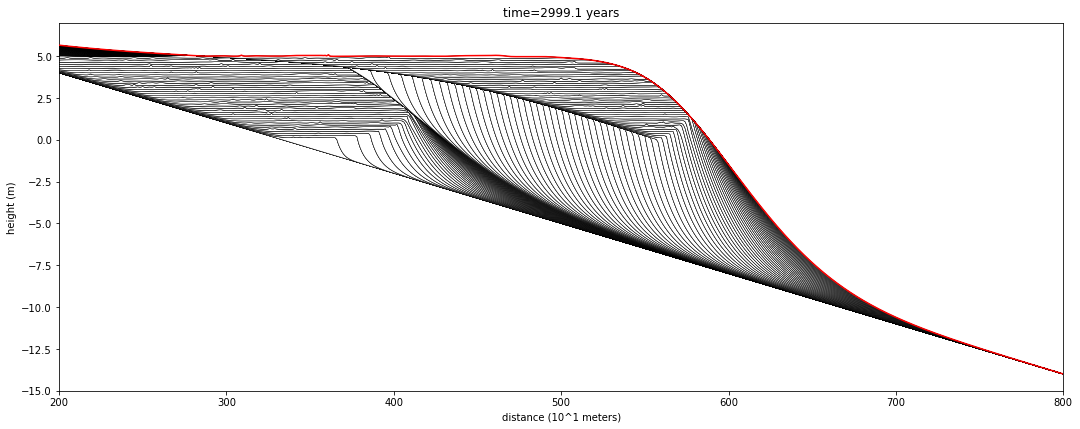

In [22]:
skip_frame=25
plot_beds(beds=beds[::skip_frame],otime=otime[::skip_frame],rsl=rsl[::skip_frame],aspect=10, ymin=-20, color=False)
plt.gca().set_ylim(-15,7)
plt.gca().set_xlim(200,800) 

<span style='color:DodgerBlue;'>  
    

1. **Which beds represent the highest sea level?**
1. **What is the magnitude of sea level change?**
1. **Can you draw the coastline change over time?** 
    
</span>

Text(0.5, 1.0, 'Constant Sea Level Rise (5 m) followed by Constant Sea Level Fall (5 m)\n with Constant Sediment Flux')

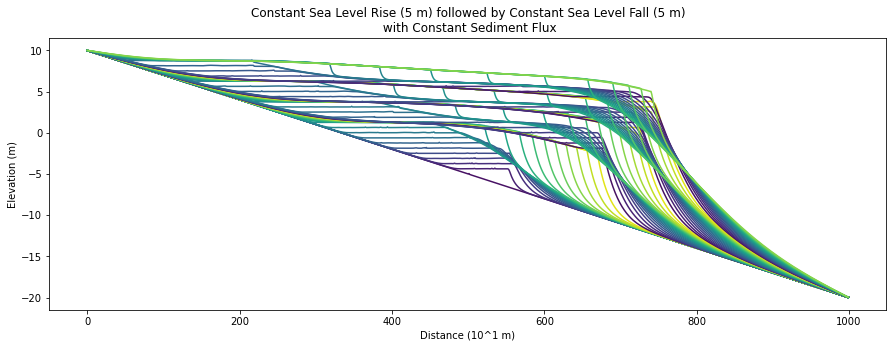

In [26]:
sns.set_palette('viridis',n_colors=21)
fig=plt.figure(figsize=(15,5))
dt = .1
total_time = 2000
base_level_rise=-5

model = Diffuse1D(length=10000, spacing=10, tstep=dt, left=10, right=-20, K=2e2, var_K=False)
xt = np.linspace(0, total_time, 1000)
RSL = np.zeros(xt.size)
RSL[:500]= -1*base_level_rise/(total_time/2)*xt[:500]
RSL[500:] =  base_level_rise/(total_time/2)*xt[500:]-2*base_level_rise

RSL = RSL.tolist()
RSL = 4*[RSL]

xt = np.linspace(0,4*total_time,4000)
model.set_baselevel(xt, np.array(RSL).ravel()+10/xt[-1]*xt-5)

beds2 = []
otime2 = []
rsl2 = []

beds2.append(model.u)
otime2.append(model.time)
rsl2.append(model.base_level)


for k in range(int(4*total_time / dt)):
    model.run_step()
    #     model.set_left(model.base_level+10)
    if k % 10 == 0:
        pbar.set_description("Processing year %s" % np.round(model.time, 1).astype(int))
        beds2.append(model.u)
        otime2.append(model.time)
        rsl2.append(model.base_level)
    if k % 1000 == 0:
        plt.plot(model.u,label="year %s" % np.round(model.time, 0))
               
plt.plot(model.u,label="year %s" % np.round(model.time, 0))
plt.gca().set_xlabel('Distance (10^1 m)')
plt.gca().set_ylabel('Elevation (m)')
plt.gca().set_title('Constant Sea Level Rise (5 m) followed by Constant Sea Level Fall (5 m)\n with Constant Sediment Flux')
# _=plt.legend(loc='best',fontsize=7)

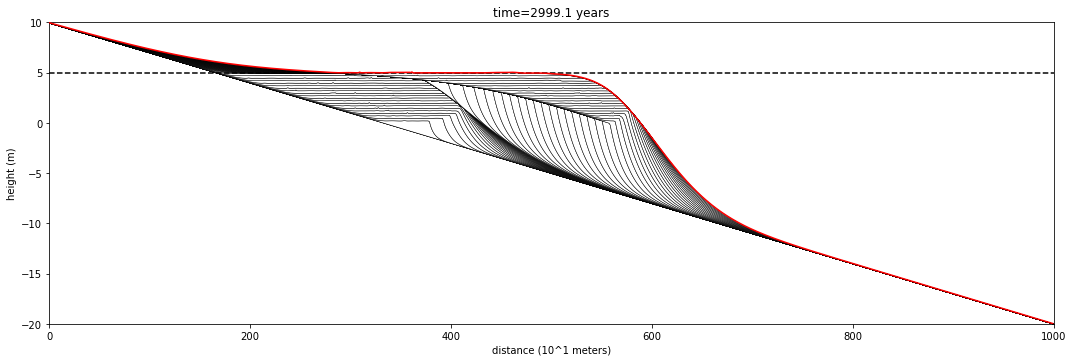

In [23]:
skip_frame=50
animate_beds(beds=beds[::skip_frame],otime=otime[::skip_frame],rsl=rsl[::skip_frame],aspect=10, ymin=-20)

<span style='color:DodgerBlue;'>  
    
1. **What is the magnitude of sea level change?**
1. **Can you draw the coastline change over time?** 
    
</span>

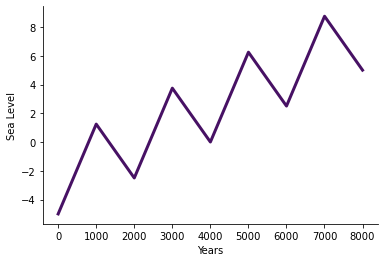

In [27]:
plt.plot(xt, np.array(RSL).ravel()+10/xt[-1]*xt-5,lw=3)
plt.gca().set_xlabel('Years')
plt.gca().set_ylabel('Sea Level')
sns.despine()

## Stratigraphic Sections
Below I have extracted a sedimentary column from the model run above. The beds are colored by the water depth they were deposited in (brighter/wider corresponds to shallower water.

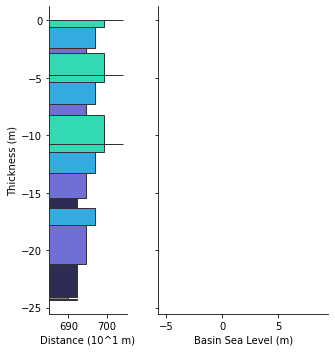

In [28]:
fig = plt.figure(figsize=(5, 5))
# print('frame %d' % count + ' of %d' %len(beds))
dx=30

plt.subplot(1,2,1)
facies_limits = [.5,-.5,-2.5,-5,-10,-2000]
facies_w = [a*.8 for a in [.8,.6,.5,.4,.3,.2]]
facies_c = ['#ffb142', #terr
           '#33d9b2', #inter
           '#34ace0', #sub
           '#706fd3', #fww
           '#2c2c54', #sww
           '#84817a'] #deep

locs=[685]
for loc in locs:
    left = loc
    strat = np.array(beds2.copy())
    rsl_strat = np.array(rsl2.copy())
    time_strat = np.array(otime2.copy())
    thicknesses = np.zeros(strat.shape[0])
    heights = np.zeros(strat.shape[0])
    water_depths = np.zeros(strat.shape[0])

    thicknesses=np.diff(strat[:,loc],prepend=strat[0,loc])
    erosive_surfaces=np.where(thicknesses<0)[0]
    erosive_surfaces=np.where(np.diff(erosive_surfaces) > 2)[0]
    thicknesses[thicknesses<0]=0
    heights=np.cumsum(thicknesses)
    water_depths=rsl_strat-strat[:,loc]

    heights = heights + (-np.max(heights))
    facies = np.zeros(water_depths.size)
    colors = np.zeros(water_depths.size).astype(str)
    water_depths = -1 * water_depths

    for j in range(len(facies_limits) - 1, -1, -1):
        facies[water_depths > facies_limits[j]] = facies_w[j] * dx
        colors[water_depths > facies_limits[j]] = facies_c[j]

    bed_facies = []
    bed_thickness = []
    bed_colors = []

    changes = np.where(np.diff(facies) != 0)[0]
    for c in [*changes, len(facies) - 1]:
        bed_facies += [facies[c]]
        bed_thickness += [heights[c]]
        bed_colors += [colors[c]]

    h = np.diff([np.min(heights), *bed_thickness])
    plt.barh(
        np.array(bed_thickness - h),
        bed_facies,
        height=h,
        left=left,
        color=bed_colors,
        align="edge",
        lw=1,
        edgecolor=(0.2, 0.2, 0.2),zorder=4
    )

plt.gca().set_aspect(3)     
plt.gca().set_xlabel('Distance (10^1 m)')
plt.gca().set_ylabel('Thickness (m)')
plt.subplot(1,2,2)

plt.plot(rsl_strat,heights,'--',alpha=0)
plt.gca().set_xlabel('Basin Sea Level (m)')
# plt.gca().set_ylabel('Thickness (m)')
plt.gca().set_yticklabels([])
sns.despine()

fig.tight_layout()

<img src='images/strat_waterdepth0.png'/>

<span style='color:DodgerBlue'>**Draw your best guess interpretation for sea level change.**</span>

## Stratigraphic Sections
Below I have extracted a sedimentary column from the model run above. The beds are colored by the water depth they were deposited in (brighter/wider corresponds to shallower water).

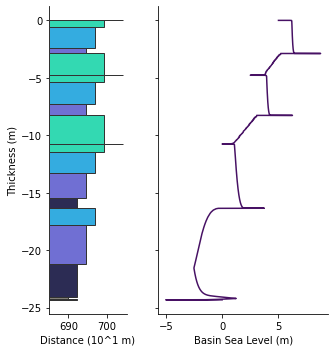

In [29]:
fig = plt.figure(figsize=(5, 5))
# print('frame %d' % count + ' of %d' %len(beds))

plt.subplot(1,2,1)
facies_limits = [.5,-.5,-2.5,-5,-10,-2000]
facies_w = [a*.8 for a in [.8,.6,.5,.4,.3,.2]]
facies_c = ['#ffb142', #terr
           '#33d9b2', #inter
           '#34ace0', #sub
           '#706fd3', #fww
           '#2c2c54', #sww
           '#84817a'] #deep

locs=[685]
for loc in locs:
    left = loc
    strat = np.array(beds2.copy())
    rsl_strat = np.array(rsl2.copy())
    time_strat = np.array(otime2.copy())
    thicknesses = np.zeros(strat.shape[0])
    heights = np.zeros(strat.shape[0])
    water_depths = np.zeros(strat.shape[0])

    thicknesses=np.diff(strat[:,loc],prepend=strat[0,loc])
    erosive_surfaces=np.where(thicknesses<0)[0]
    erosive_surfaces=np.where(np.diff(erosive_surfaces) > 2)[0]
    thicknesses[thicknesses<0]=0
    heights=np.cumsum(thicknesses)
    water_depths=rsl_strat-strat[:,loc]

    heights = heights + (-np.max(heights))
    facies = np.zeros(water_depths.size)
    colors = np.zeros(water_depths.size).astype(str)
    water_depths = -1 * water_depths

    for j in range(len(facies_limits) - 1, -1, -1):
        facies[water_depths > facies_limits[j]] = facies_w[j] * dx
        colors[water_depths > facies_limits[j]] = facies_c[j]

    bed_facies = []
    bed_thickness = []
    bed_colors = []

    changes = np.where(np.diff(facies) != 0)[0]
    for c in [*changes, len(facies) - 1]:
        bed_facies += [facies[c]]
        bed_thickness += [heights[c]]
        bed_colors += [colors[c]]

    h = np.diff([np.min(heights), *bed_thickness])
    plt.barh(
        np.array(bed_thickness - h),
        bed_facies,
        height=h,
        left=left,
        color=bed_colors,
        align="edge",
        lw=1,
        edgecolor=(0.2, 0.2, 0.2),zorder=4
    )

plt.gca().set_aspect(3)    
plt.gca().set_xlabel('Distance (10^1 m)')
plt.gca().set_ylabel('Thickness (m)')
plt.subplot(1,2,2)

plt.plot(rsl_strat,heights,'-',alpha=1)
plt.gca().set_xlabel('Basin Sea Level (m)')
# plt.gca().set_ylabel('Thickness (m)')
plt.gca().set_yticklabels([])
sns.despine()

fig.tight_layout()

<img src='images/strat_waterdepth.png'/>

<span style='color:DodgerBlue'>**How did you do? What is happening?**</span>

coastline motion decoupled from sea level change -- why?  function of accommodation space and sediment flux!
for example, infinitely high sediment flux would lead to coastline progradation no matter what

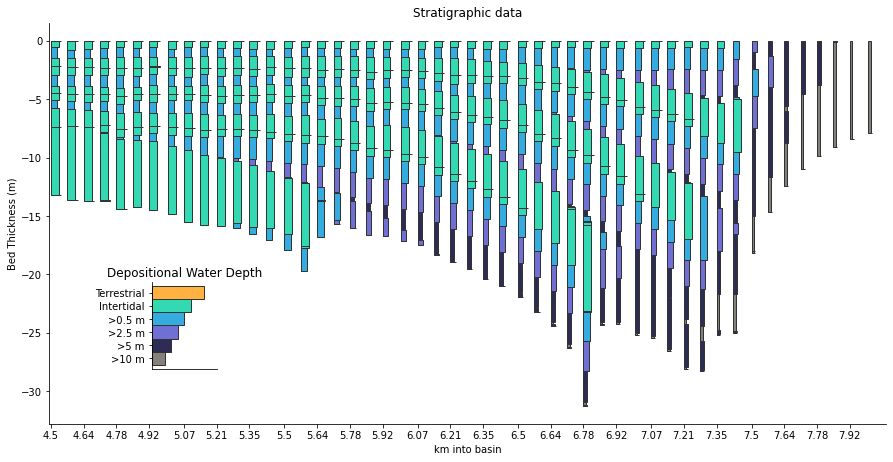

In [30]:
fig=plt.figure(figsize=(15,8))
N=50
start=450
end=800
locs = np.linspace(start, end, N).astype(int)
dx = np.diff(locs)[0]

facies_limits = [.5,-.5,-2.5,-5,-10,-2000]
facies_w = [a*.8 for a in [.8,.6,.5,.4,.3,.2]]
facies_c = ['#ffb142', #terr
           '#33d9b2', #inter
           '#34ace0', #sub
           '#706fd3', #fww
           '#2c2c54', #sww
           '#84817a'] #deep

for loc in locs:
    left = loc
    strat = np.array(beds2.copy())
    rsl_strat = np.array(rsl2.copy())
    time_strat = np.array(otime2.copy())
    thicknesses = np.zeros(strat.shape[0])
    heights = np.zeros(strat.shape[0])
    water_depths = np.zeros(strat.shape[0])

    thicknesses=np.diff(strat[:,loc],prepend=strat[0,loc])
    erosive_surfaces=np.where(thicknesses<0)[0]
    erosive_surfaces=np.where(np.diff(erosive_surfaces) > 2)[0]
    thicknesses[thicknesses<0]=0
    heights=np.cumsum(thicknesses)
    water_depths=rsl_strat-strat[:,loc]

    heights = heights + (-np.max(heights))
    facies = np.zeros(water_depths.size)
    colors = np.zeros(water_depths.size).astype(str)
    water_depths = -1 * water_depths

    for j in range(len(facies_limits) - 1, -1, -1):
        facies[water_depths > facies_limits[j]] = facies_w[j] * dx
        colors[water_depths > facies_limits[j]] = facies_c[j]

    bed_facies = []
    bed_thickness = []
    bed_colors = []

    changes = np.where(np.diff(facies) != 0)[0]
    for c in [*changes, len(facies) - 1]:
        bed_facies += [facies[c]]
        bed_thickness += [heights[c]]
        bed_colors += [colors[c]]

    h = np.diff([np.min(heights), *bed_thickness])
    plt.barh(
        np.array(bed_thickness - h),
        bed_facies,
        height=h,
        left=left,
        color=bed_colors,
        align="edge",
        lw=1,
        edgecolor=(0.2, 0.2, 0.2),zorder=4
    )


    
#     plt.barh(
#         np.array(bed_thickness - h),
#         bed_facies,
#         height=h,
#         left=left,
#         color=bed_colors,
#         align="edge",
#         lw=1,
#         edgecolor=(0.2, 0.2, 0.2),zorder=0
#     )

#     if erosive_surfaces.size>0:
#         _=plt.plot([left,left+dx],[heights[erosive_surfaces]]*2,'r--',lw=.5)

plt.gca().set_aspect(5)
sns.despine()
plt.gca().set_xticks(locs[::2])
plt.gca().set_xticklabels(locs[::2]/100)
plt.gca().set_xlabel('km into basin')
plt.gca().set_ylabel('Bed Thickness (m)')
# plt.gca().set_yticks([-200,-175,-150,-125,-100,-75,-50,-25,0])
# plt.gca().set_yticklabels([200,175,150,125,100,75,50,25,0][::-1])
plt.gca().set_title('Stratigraphic data')
plt.gca().set_xlim(locs[0]-dx*.1,locs[-1]+1.1*dx)

# this is an inset axes over the main axes
a = plt.axes([.15, .25, .2, .15])
plt.barh(
    [0,1,2,3,4,5],
    [.8,.6,.5,.4,.3,.2][::-1],
    height=[1,1,1,1,1,1],
    left=0,
    color=facies_c[::-1],
    align="edge",
    lw=1,
    edgecolor=(0.2, 0.2, 0.2),
)
plt.gca().set_xlim([0,1])
plt.gca().set_yticks([0.5 + n for n in range(6)])
plt.gca().set_yticklabels(['>10 m','>5 m','>2.5 m','>0.5 m','Intertidal','Terrestrial'])
plt.gca().set_title('Depositional Water Depth')
plt.gca().set_xticks([])
plt.gca().set_aspect(.2)
sns.despine()

<center><img src='images/strat_waterdepth1.png'/></center>

In [ ]:
%matplotlib agg

N=50
start=450
end=800
locs = np.linspace(start, end, N).astype(int)
dx = np.diff(locs)[0]

facies_limits = [.5,-.5,-2.5,-5,-10,-2000]
facies_w = [a*.8 for a in [.8,.6,.5,.4,.3,.2]]
facies_c = ['#ffb142', #terr
           '#33d9b2', #inter
           '#34ace0', #sub
           '#706fd3', #fww
           '#2c2c54', #sww
           '#84817a'] #deep

counter=10
count=0
for end_frame in range(0,len(beds2.copy()),counter):
    fig=plt.figure(figsize=(15,8))
    print('frame %d' % count + ' of %d' %(len(beds2)/counter))
    clear_output(wait=True)
    for loc in locs:
        left = loc
        strat = np.array(beds2.copy())[:end_frame]
        if strat.size>0:
            rsl_strat = np.array(rsl2.copy())[:end_frame]
            time_strat = np.array(otime2.copy())[:end_frame]
            thicknesses = np.zeros(strat.shape[0])
            heights = np.zeros(strat.shape[0])
            water_depths = np.zeros(strat.shape[0])

            thicknesses=np.diff(strat[:,loc],prepend=strat[0,loc])
            erosive_surfaces=np.where(thicknesses<0)[0]
            erosive_surfaces=np.where(np.diff(erosive_surfaces) > 2)[0]
            thicknesses[thicknesses<0]=0
            heights=np.cumsum(thicknesses)
            water_depths=rsl_strat-strat[:,loc]

            heights = heights + (-np.max(heights))
            facies = np.zeros(water_depths.size)
            colors = np.zeros(water_depths.size).astype(str)
            water_depths = -1 * water_depths

            for j in range(len(facies_limits) - 1, -1, -1):
                facies[water_depths > facies_limits[j]] = facies_w[j] * dx
                colors[water_depths > facies_limits[j]] = facies_c[j]

            bed_facies = []
            bed_thickness = []
            bed_colors = []

            changes = np.where(np.diff(facies) != 0)[0]
            for c in [*changes, len(facies) - 1]:
                bed_facies += [facies[c]]
                bed_thickness += [heights[c]]
                bed_colors += [colors[c]]

            h = np.diff([np.min(heights), *bed_thickness])
            plt.barh(
                np.array(bed_thickness - h),
                bed_facies,
                height=h,
                left=left,
                color=bed_colors,
                align="edge",
                lw=1,
                edgecolor=(0.2, 0.2, 0.2),zorder=4
            )



        #     plt.barh(
        #         np.array(bed_thickness - h),
        #         bed_facies,
        #         height=h,
        #         left=left,
        #         color=bed_colors,
        #         align="edge",
        #         lw=1,
        #         edgecolor=(0.2, 0.2, 0.2),zorder=0
        #     )

        #     if erosive_surfaces.size>0:
        #         _=plt.plot([left,left+dx],[heights[erosive_surfaces]]*2,'r--',lw=.5)

    plt.gca().set_aspect(5)
    sns.despine()
    plt.gca().set_xticks(locs[::2])
    plt.gca().set_xticklabels(locs[::2]/100)
    plt.gca().set_xlabel('km into basin')
    plt.gca().set_ylabel('Bed Thickness (m)')
    plt.gca().set_ylim([-33,3])
    # plt.gca().set_yticks([-200,-175,-150,-125,-100,-75,-50,-25,0])
    # plt.gca().set_yticklabels([200,175,150,125,100,75,50,25,0][::-1])
    plt.gca().set_title('Stratigraphic data')
    plt.gca().set_xlim(locs[0]-dx*.1,locs[-1]+1.1*dx)

    # this is an inset axes over the main axes
    a = plt.axes([.15, .25, .2, .15])
    plt.barh(
        [0,1,2,3,4,5],
        [.8,.6,.5,.4,.3,.2][::-1],
        height=[1,1,1,1,1,1],
        left=0,
        color=facies_c[::-1],
        align="edge",
        lw=1,
        edgecolor=(0.2, 0.2, 0.2),
    )
    plt.gca().set_xlim([0,1])
    plt.gca().set_yticks([0.5 + n for n in range(6)])
    plt.gca().set_yticklabels(['>10 m','>5 m','>2.5 m','>0.5 m','Intertidal','Terrestrial'])
    plt.gca().set_title('Depositional Water Depth')
    plt.gca().set_xticks([])
    plt.gca().set_aspect(.2)
    sns.despine()
    fig.savefig("strat_sequences/frame%s.jpg" % str(count).zfill(6))
    count+=1
    
%matplotlib inline

<center><video style='display: block;
margin: 0 auto;' controls src='videos/strat_movie.mp4'/></center>

<video controls src='videos/animation_cycles1.mp4'/>